# Auto-Encoder (TODO)

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds

import librosa
import librosa.display

import numpy as np
from matplotlib import pyplot as plt

from pathlib import Path

from IPython.display import Audio

In [2]:
import dpmhm

from dpmhm.datasets import transformer, preprocessing, feature, utils

First we load the dataset `CWRU` into memory. The original dataset doesn't specify the split, and all data are contained in the field `train`.

In [3]:
dataset_name = 'CWRU'

ds_all, ds_info = tfds.load(
    dataset_name, 
    # data_dir='/home/han/Database/tensorflow_datasets/',
    # split=['train[:75%]', 'train[75%:]'],    
    with_info=True,
    download=False,
    # batch_size=-1,  # load the whole dataset into a single batch
#     download_and_prepare_kwargs
)

print(ds_all.keys())  # show the split of the raw dataset

ds0 = ds_all['train']

dict_keys(['train'])


2022-12-23 10:42:27.478985: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-23 10:42:27.479017: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Pluto): /proc/driver/nvidia/version does not exist
2022-12-23 10:42:27.484560: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


The method `.element_spec()` shows the specification of elements. All dataset of `dpmhm` contains the fields `{'label', 'signal', 'sampling_rate', 'metadata'}`. The meta-information about the record is stored in  'metadata' which is specific to every dataset.

In [4]:
ds0.element_spec

{'label': TensorSpec(shape=(), dtype=tf.int64, name=None),
 'metadata': {'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None),
  'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
  'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
  'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
  'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None)},
 'sampling_rate': TensorSpec(shape=(), dtype=tf.uint32, name=None),
 'signal': {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None),
  'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}}

We note for CWRU that (not a general rule for other datasets of `dpmhm`)
- `metadata` has a subfiled `FaultLocation`, but this is a redundant copy of the field `label`.
- The normal data can be equivalently identified by any of the following clauses: `label==0`, `FaultComponent==None`, `FaultSize==0`.


Let's plot and play a sample from the dataset:

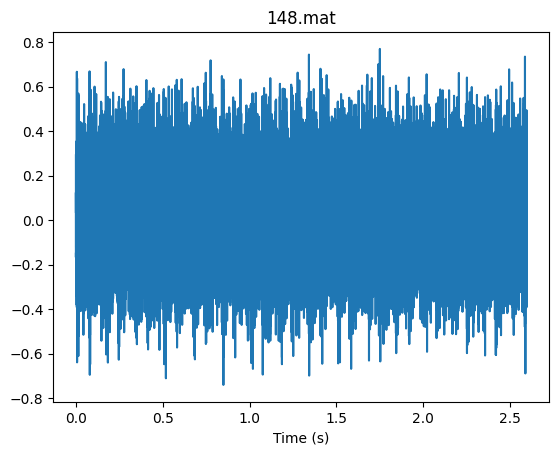

In [23]:
eles = list(ds0.take(10).as_numpy_iterator())

fn = eles[0]['metadata']['FileName'].decode()
sr = eles[0]['sampling_rate']
x = eles[0]['signal']['FE']

plt.figure()
plt.plot(np.arange(len(x))/sr, x)
plt.xlabel('Time (s)')
plt.title(fn)

Audio(x, rate=sr)

## File-level preprocessing

These are the preprocessing applied at the level of original records (or data files). 

#### Filter on the channels
CWRU contains 3 channels ['DE', 'FE', 'BA'], however some channels may be absent in certain files (e.g. the file `148.mat` contains only channels 'DE' and 'FE', not 'BA'). A first preprocessing step hence consists in selecting only the files in which some desired channels are simultaneously present. 

#### Ramification of labels
The original label takes value in ['None', 'DriveEnd', 'FanEnd'] (or the numeric value [0,1,2]), meaning that
- there is no fault
- the fault locates at the drive-end
- the fault locates at the fan-end

We want to incorporate more information and make new labels at a finer level. For this, we take into account the subfield `FaultComponent` and `FaultSize` of the field `metadata`:
- `FaultComponent`: taking value in {'InnerRace', 'Ball', 'OuterRace3', 'OuterRace6', 'OuterRace12', 'None'}
- `FaultSize`: taking value in {0.007, 0.014, 0.021, 0.028, 0}

Together with the original label, the new label becomes a triplet `(label, FaultComponent, FaultSize)`. For example, the triplet `(1, 'InnerRace', 0.007)` means the fault is located at drive-end, on the inner-race component, of size 0.007.

#### Resampling & sliding window view
The record in CWRU has variant duration (~10 or 2.5 seconds) and sampling rate (at 12000 or 48000 Hz) which may complicate the subsequent analysis. So we resample all signals at the fixed rate of 16000 Hz and trim them into windows of 1 second with hop size 0.5 second.

#### Selection of domain 
We define *domain* as the operating load force of a record. Note that in CWRU the field `LoadForce` (taking value in [0,1,2,3]) is one-to-one mapped to the nominal RPM `NominalRPM` (taking value in [797, 1772, 1750, 1730]). We want to test if an algorithm of detection trained on some domains can work on the others (called *domain-shift*).



### `DatasetCompactor` class

The class `dpmhm.datasets.transformer.DatasetCompactor` provides functionalities for the file-level preprocessing. Let's define the parameters of preprocessing and construct a compactor object. 

In [117]:
# Filter on the channels
channels = ['DE', 'FE', 'BA']  # containing all channels
# channels = ['DE']  # containing only the channel 'DE'

# Label ramification
keys = ['FaultComponent', 'FaultSize']  # finest label
# keys = []  # original label

# Selection of domain
# filters = {'LoadForce': [0,1,2]}  # source domain
filters = {}

# Resampling rate
resampling_rate = 16000
# resampling_rate = None  # no resampling

# Size of the sliding window (after resampling)
window_size = 16000  # 1 second

# Number of samples between sucessive window
hop_size = 8000

from dpmhm.datasets import transformer

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, filters=filters,
                                         resampling_rate=resampling_rate, 
                                         window_size=window_size, hop_size=hop_size)

The new construction has the property `dataset` which is the transformed dataset. Let's compare the new signature of 'signal' to the original one:

In [184]:
ds1 = compactor.dataset

print('Original:', ds0.element_spec['signal'])

print('Compacted:', ds1.element_spec['signal'])

Original: {'BA': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'DE': TensorSpec(shape=(None,), dtype=tf.float32, name=None), 'FE': TensorSpec(shape=(None,), dtype=tf.float32, name=None)}
Compacted: TensorSpec(shape=(3, None), dtype=tf.float32, name=None)


And take some elements from the new dataset:

In [134]:
eles1 = list(ds1.take(10).as_numpy_iterator())
eles0 = list(ds0.take(10).as_numpy_iterator())

As expected, the new field 'signal' is now a 2D-array of fixed shape (3 channels and 16000 points):

In [135]:
for n, X in enumerate(eles1):
    print(n, f"label={X['label'].decode()}, shape={X['signal'].shape}")

0 label=d39d8931, shape=(3, 16000)
1 label=d39d8931, shape=(3, 16000)
2 label=d39d8931, shape=(3, 16000)
3 label=d39d8931, shape=(3, 16000)
4 label=d39d8931, shape=(3, 16000)
5 label=d39d8931, shape=(3, 16000)
6 label=d39d8931, shape=(3, 16000)
7 label=d39d8931, shape=(3, 16000)
8 label=d39d8931, shape=(3, 16000)
9 label=d39d8931, shape=(3, 16000)


To find out the meaning of new labels, use the property `compactor.full_label_dict`. It can be seen that the label `d39d8931` corresponds to the category `FaultLocation=2` (2 for 'FanEnd'), `FaultComponent='InnerRace'` and `FaultSize=0.014`.

In [136]:
compactor.full_label_dict

{'d39d8931': ['2', 'InnerRace', '0.014'],
 'a126b311': ['1', 'Ball', '0.007'],
 'ada901bd': ['2', 'Ball', '0.014'],
 '10d51e0c': ['1', 'OuterRace6', '0.014'],
 '19b7c8c9': ['1', 'OuterRace12', '0.007'],
 'ecb9fb89': ['2', 'InnerRace', '0.007'],
 '6607c34e': ['2', 'OuterRace3', '0.014'],
 'aa676c6c': ['1', 'Ball', '0.021'],
 '2c9f2adc': ['2', 'OuterRace3', '0.007'],
 '445d82dc': ['1', 'OuterRace12', '0.021'],
 '53138cc8': ['1', 'Ball', '0.014'],
 'faff6146': ['1', 'InnerRace', '0.021'],
 'f9b9bb12': ['2', 'OuterRace3', '0.021'],
 '1f9da202': ['1', 'OuterRace3', '0.007'],
 '4b9452e7': ['2', 'InnerRace', '0.021'],
 '6a669739': ['1', 'OuterRace3', '0.021'],
 '894b6e49': ['2', 'Ball', '0.021'],
 '04941fda': ['2', 'OuterRace6', '0.007'],
 '7e297d6f': ['2', 'Ball', '0.007'],
 '921c54c7': ['2', 'OuterRace12', '0.007'],
 'ca79b89c': ['1', 'InnerRace', '0.014'],
 '9b317898': ['1', 'OuterRace6', '0.007'],
 '42be485a': ['1', 'InnerRace', '0.007'],
 '758085eb': ['1', 'OuterRace6', '0.021'],
 '7b612

We notice also that the several first elements in the new dataset all have the same `metadata`: this is of cause due to the sliding window view on the same data file '274.mat'.

In [120]:
for X in eles1:
    print(X['metadata'])

{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.014, 'FileName': b'274.mat', 'LoadForce': 0, 'NominalRPM': 1797, 'RPM': 1796}
{'FaultComponent': b'InnerRace', 'FaultLocation': b'FanEnd', 'FaultSize': 0.

Actually the first two records of the new dataset has a common part of the length of hop size:

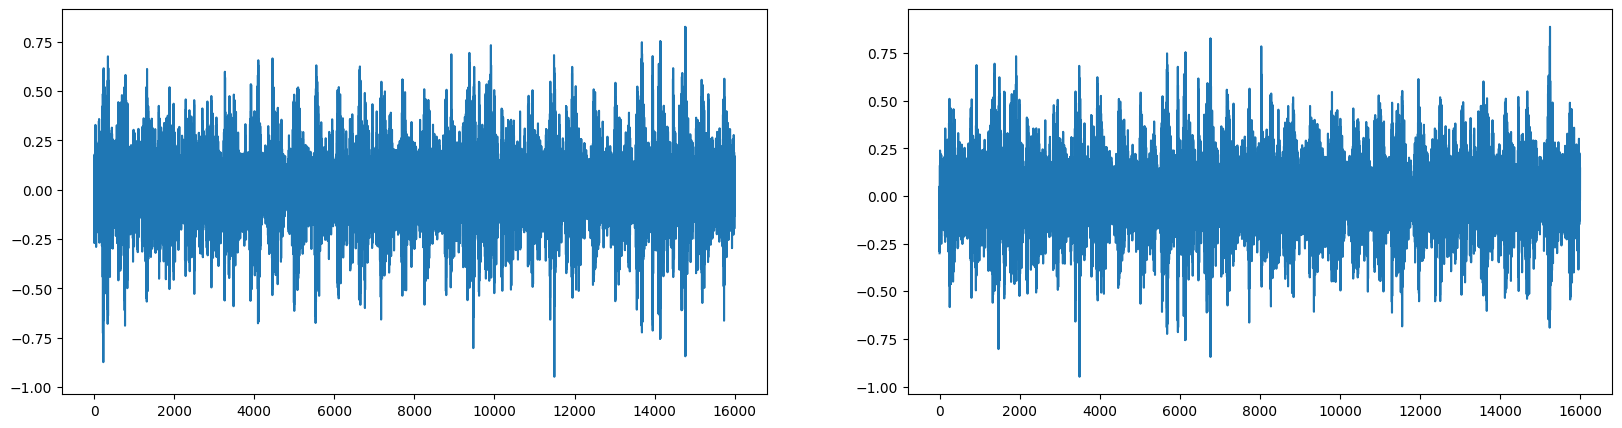

In [171]:
x0, x1 = eles1[0]['signal'], eles1[1]['signal']

fig, axes = plt.subplots(1,2, figsize=(20,5))
axes[0].plot(x0[0])
axes[1].plot(x1[0])

assert np.allclose(x0[0][hop_size:], x1[0][:hop_size])

## Data-level preprocessing

In [5]:
from dpmhm.datasets import feature

# File-level parameters
channels = ['DE', 'FE']

keys = ['FaultComponent', 'FaultSize']  # finest label

compactor = transformer.DatasetCompactor(ds0, channels=channels, keys=keys, resampling_rate=12000)

_func = lambda x, sr: feature.spectrogram(x, sr, time_window=0.025, hop_step=0.0125, 
                                          to_db=True, normalize=False)

# _func = lambda x, sr: feature.melspectrogram(x, sr, time_window=0.025, hop_step=0.0125, 
#                                              n_mels=128, normalize=False)

extractor = transformer.FeatureExtractor(compactor.dataset, _func)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


The feature-transformed dataset is again contained in the property `.dataset`. Let's take some elements from it.

In [5]:
ds2 = extractor.dataset

eles2 = list(ds2.take(10).as_numpy_iterator())

The feature transformed dataset shares the same `label` and `metadata` of the compacted dataset:

In [6]:
ds1 = compactor.dataset
eles1 = list(ds1.take(10).as_numpy_iterator())

assert eles2[0]['metadata'] == eles1[0]['metadata']

assert eles2[0]['label'] == eles1[0]['label']

But the field `signal` is now replaced by `feature` which is the spectrogram of the original signal. It is a fixed-size 3D array with axes `(channel, frequency, time)`.

In [7]:
eles2[2]['feature'].shape

(2, 257, 811)

Text(0, 0.5, 'Frequency bin')

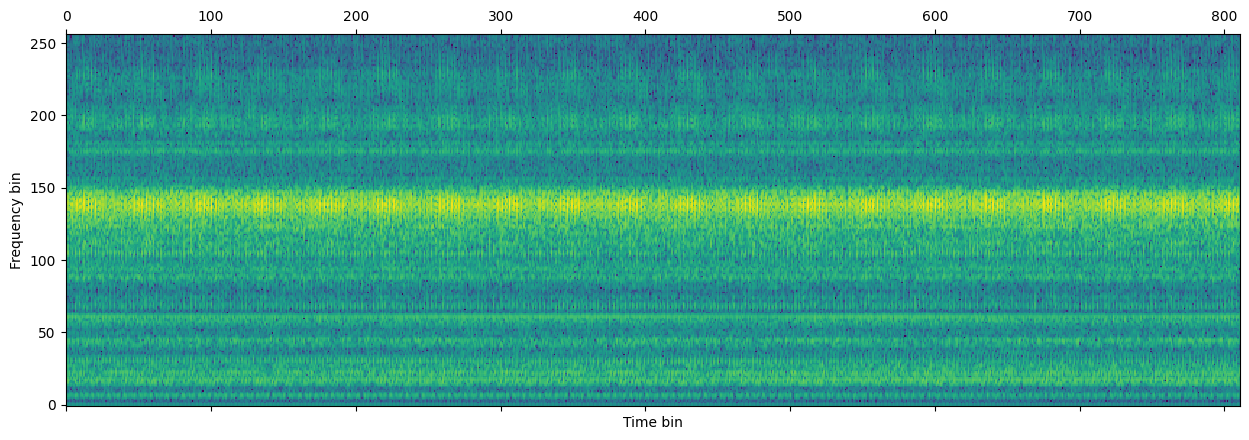

In [8]:
X = eles2[9]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

In [23]:
window = transformer.WindowSlider(extractor.dataset, window_size=(64,64), hop_size=(32,32))

ds3 = window.dataset

# ds3 = Dataset.from_generator(
#     utils.sliding_window_generator(ds2, 'feature', 64, 32),
#     output_signature=ds2.element_spec,
# )

eles3 = list(ds3.take(10).as_numpy_iterator())

Text(0, 0.5, 'Frequency bin')

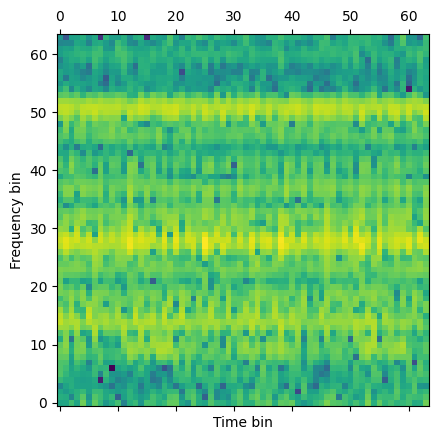

In [324]:
X = eles3[9]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

### SpecAugmentation

In [62]:
specaug = transformer.SpecAugment(extractor.dataset)

ds4 = specaug.dataset

eles4 = list(ds4.take(20).as_numpy_iterator())

2022-12-23 11:05:06.061417: W tensorflow/core/framework/op_kernel.cc:1818] UNKNOWN: AttributeError: 'tuple' object has no attribute 'ndim'
Traceback (most recent call last):

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/han/Projects/HIASCI/Codes/Developments/dpmhm/dpmhm/datasets/transformer.py", line 476, in <lambda>
    self.spec_aug = lambda x: _fade(_blur(_flip(_cr

UnknownError: {{function_node __wrapped__IteratorGetNext_output_types_9_device_/job:localhost/replica:0/task:0/device:CPU:0}} AttributeError: 'tuple' object has no attribute 'ndim'
Traceback (most recent call last):

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/han/Projects/HIASCI/Codes/Developments/dpmhm/dpmhm/datasets/transformer.py", line 476, in <lambda>
    self.spec_aug = lambda x: _fade(_blur(_flip(_crop(x))))

  File "/home/han/Projects/HIASCI/Codes/Developments/dpmhm/dpmhm/datasets/spec_augment.py", line 35, in _func
    return func(X, *args, **kwargs)

  File "/home/han/Projects/HIASCI/Codes/Developments/dpmhm/dpmhm/datasets/transformer.py", line 464, in _blur
    return skimage.filters.gaussian(x, sigma=blur_kwargs['sigma'], channel_axis=0)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/skimage/_shared/utils.py", line 348, in fixed_func
    return func(*args, **kwargs)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/skimage/_shared/filters.py", line 116, in gaussian
    if image.ndim == 3 and image.shape[-1] == 3 and channel_axis is None:

AttributeError: 'tuple' object has no attribute 'ndim'


	 [[{{node EagerPyFunc}}]] [Op:IteratorGetNext]

2022-12-23 11:05:06.574705: W tensorflow/core/framework/op_kernel.cc:1818] INVALID_ARGUMENT: ValueError: could not broadcast input array from shape (2,64,64) into shape (2,)
Traceback (most recent call last):

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 269, in __call__
    return func(device, token, args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 147, in __call__
    outputs = self._call(device, args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/ops/script_ops.py", line 154, in _call
    ret = self._func(*args)

  File "/home/han/.pyenv/versions/dev310/lib/python3.10/site-packages/tensorflow/python/autograph/impl/api.py", line 642, in wrapper
    return func(*args, **kwargs)

  File "/home/han/Projects/HIASCI/Codes/Developments/dpmhm/dpmhm/datasets/transformer.py", line 476, in <lambda>
    self.spec_au

In [63]:
import skimage

In [64]:
skimage.transform.resize_local_mean?

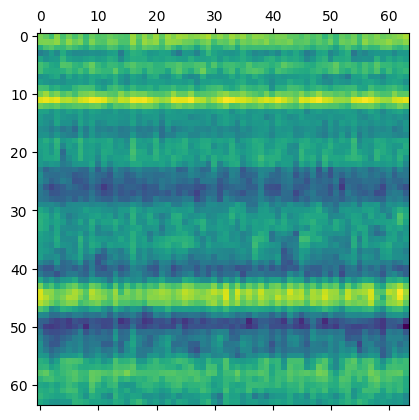

In [61]:
X = eles4[3]['feature']

plt.matshow(X[1])
# plt.matshow(np.flip(X, axis=-1)[1])

Text(0, 0.5, 'Frequency bin')

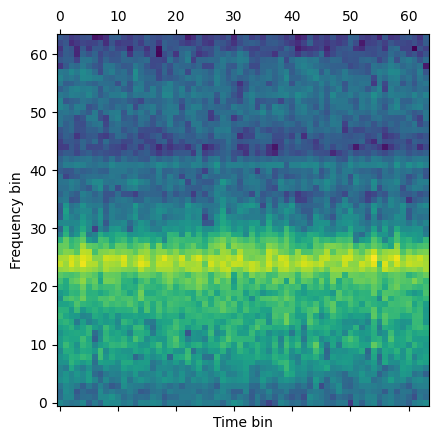

In [19]:
X = eles4[1]
plt.matshow(X['feature'][0], origin='lower')
plt.xlabel('Time bin')
plt.ylabel('Frequency bin')

In [15]:
eles4[0]

{'label': b'1f9da202',
 'metadata': {'FaultComponent': b'OuterRace3',
  'FaultLocation': b'DriveEnd',
  'FaultSize': 0.007,
  'FileName': b'148.mat',
  'LoadForce': 0,
  'NominalRPM': 1797,
  'RPM': 1797},
 'feature': array([[[ 12.063647  ,  10.921406  ,  14.42482   , ...,  11.955994  ,
           12.493002  ,  12.800921  ],
         [ 11.773015  ,   5.05389   ,  13.858406  , ...,  11.863455  ,
           12.821177  ,  13.830965  ],
         [ 11.159904  ,   7.382079  ,  12.77033   , ...,   9.697359  ,
           12.090165  ,  10.89319   ],
         ...,
         [-49.89227   , -49.89227   , -49.89227   , ..., -49.89227   ,
          -49.89227   , -49.892273  ],
         [-49.89227   , -49.89227   , -49.89227   , ..., -49.89227   ,
          -49.89227   , -49.892273  ],
         [-49.89227   , -49.89227   , -49.89227   , ..., -49.89227   ,
          -49.89227   , -49.892273  ]],
 
        [[ -7.748051  ,   2.830787  ,   4.081166  , ...,   5.882562  ,
            3.3393512 ,   1.321971 

In [6]:
outdir = Path('/home/han/tmp/') / dataset_name / 'spectrogram'
# extractor = lambda x, sr: feature.melspectrogram(x, sr, time_window=0.025, hop_step=0.0125, n_mels=128, normalize=True)
# outdir = Path('/home/han/tmp/cwru/mel')

window_shape = (64, 64)
downsample = (64, 64)

# window_shape = 64
# downsample = 64

#### For full domain-adaptation

Transfer learning is applied (training & validation) on the full domain LoadForce=[0,1,2,3]

In [5]:
compactor = preprocessing.DatasetCompactor(ds0, keys=keys, channels=channels)

extractor = preprocessing.FeatureExtractor(compactor.dataset, _extractor)

slider = preprocessing.WindowSlider(extractor.dataset, window_shape=window_shape, downsample=downsample)

fp = tempfile.mkdtemp()

slider.serialize(fp)

# dss = slider.dataset.shuffle(buffer_size=5000, seed=1234)
# dss = slider.dataset.take(5)
paired_pos = preprocessing.PairedView(slider.dataset, keys=['FileName'], positive=True)
paired_neg = preprocessing.PairedView(slider.dataset, keys=['FileName'], positive=False)

# paired_pos.dataset
# paired_neg.dataset

In [60]:
paired_neg.dataset.element_spec

({'label': TensorSpec(shape=<unknown>, dtype=tf.string, name=None),
  'metadata': {'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
   'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
   'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
   'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'LoadForce': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'RPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'FaultLocation': TensorSpec(shape=(), dtype=tf.string, name=None)},
  'feature': TensorSpec(shape=(3, 64, 64), dtype=tf.float32, name=None)},
 {'label': TensorSpec(shape=<unknown>, dtype=tf.string, name=None),
  'metadata': {'FaultSize': TensorSpec(shape=(), dtype=tf.float32, name=None),
   'FaultComponent': TensorSpec(shape=(), dtype=tf.string, name=None),
   'FileName': TensorSpec(shape=(), dtype=tf.string, name=None),
   'NominalRPM': TensorSpec(shape=(), dtype=tf.uint32, name=None),
   'LoadForce': TensorSpec(sh

In [59]:
for x in paired_pos.dataset.take(10).as_numpy_iterator():
    print(x[0]['label'], x[1]['label'])
    print(x[0]['metadata'], x[1]['metadata'])

b'd39d8931' b'd39d8931'
{'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'} {'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'}
b'd39d8931' b'd39d8931'
{'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'} {'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'}
b'd39d8931' b'd39d8931'
{'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'} {'FaultSize': 0.014, 'FaultComponent': b'InnerRace', 'FileName': b'276.mat', 'NominalRPM': 1750, 'LoadForce': 2, 'RPM': 1755, 'FaultLocation': b'FanEnd'}
b'd3

In [20]:
dc_kwargs = {
    'keys': keys,
    'channels': channels,
#     'filters': {'LoadForce': [0,1,2]}
    # 'resampling_rate': 16000
}

ft_kwargs = {
    'window_shape': window_shape,
    'downsample': downsample
}

preprocessor = preprocessing.Preprocessor(ds0, extractor, dc_kwargs=dc_kwargs, ft_kwargs=ft_kwargs)

# %time preprocessor.dataset_windows.save(str(outdir/'full_domain'))

labels = list(preprocessor.label_dict.keys())

# preprocessor.dataset_windows  # reloaded dataset with better performance

In [22]:
ele = list(preprocessor.dataset_feature.take(1))[0]

X = ele['feature']

plt.imshow(X.numpy().squeeze(), aspect='auto')

In [4]:
dw = tf.data.Dataset.load(str(outdir/'full_domain'))

splits = {'train':0.1, 'val':0.7, 'test':0.2}
# splits = {'train':0.8, 'val':0.2}
# splits = {'train':1.0, 'val':0.}

sp_kwargs = {
    'shuffle_size': None,
    'reshuffle_each_iteration': False,
}

# These two ways of split give similar results:
# %time dw_split = utils.split_dataset(dw, splits, labels=None, **sp_kwargs)  # uniformly random split
%time dw_split = utils.split_dataset(dw, splits, labels=labels, **sp_kwargs)  # Few-shot style split, much slower

for k, ds in dw_split.items():
    print(k, utils.get_dataset_size(ds))  # len(ds) might not work here, use utils.get_dataset_size(ds)

NameError: name 'labels' is not defined

NameError: name 'dw_split' is not defined

In [7]:
# Optionally, save & load again the split dataset for better performance

# for k,v in dw_split.items():
#     v.save(str(outdir/'full_domain'/str(splits)/k))    

# dw_split = {}
# for p in (outdir/'full_domain'/str(splits)).iterdir():
#     dw_split[p.name] = tf.data.Dataset.load(str(p))      
    
# # Loading from files makes the size information available 
# for k, ds in dw_split.items():
#     print(k, len(ds))        